# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

---

# Problem Statement 

The goal of this project is to combine transaction, demographic, and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

This goal can be achieved by following the below-mentioned strategies:

* Exploring and Visualizaing the Data.
* Applying Quick Data Analysis.
* Preprocessing the data.
* Scaling the numerical features.
* Trying several Supervised Learning Models.
* Evaluating the models using the chosen metric (Accuracy)- Choosing the best model among them.
* If the results need to be improved, implementing GridSearchCV to find the best parameters (in order to improve the performance of the chosen model).

---

# Metrics 

In order to evaluate our model's performance, we will use accuracy. This Metric was chosen for the following reasons :

* Since we have a simple classification problem, i.e. either:
    * offer viewed
    * offer completed.
* It enables us to recognize HOW WELL our model is predicting by comparing the number of correct predictions with the total number of predictions ( the concept of accuracy).

---

In [1]:
#import libraries and dependencies
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
sns.set_palette('pastel')
%matplotlib inline
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# Defining parameters for figures and charts
color = color_discrete_sequence=px.colors.qualitative.Pastel

---

# Exploratory Analysis and Data Cleansing

---

### 1. Portfolio

In [4]:
def clean_portfolio(portfolio):
    
    '''
    Function to clean the portoflio dataset. Encode the categorical variables.
    
    Input - Portfolio dataframe
    
    Output - Portfolio dataframe with categorical variables handled
    '''
    
    #Apply one hot encodings to channels column
    
    #Email
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    #Mobile
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    #Social
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    #Web
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    #Create dummy columns for offer_type
    offer_types = pd.get_dummies(portfolio['offer_type'], prefix ='offer_type', prefix_sep='-')
    
    portfolio = pd.concat([portfolio.drop(['offer_type','channels'],axis=1),offer_types],axis=1)
      
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return portfolio
portfolio = clean_portfolio(portfolio)

In [5]:
portfolio.head()

reward  difficulty  duration                          offer_id  email  \
0      10          10         7  ae264e3637204a6fb9bb56bc8210ddfd      1   
1      10          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0      1   
2       0           0         4  3f207df678b143eea3cee63160fa8bed      1   
3       5           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
4       5          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7      1   

   mobile  social  web  offer_type-bogo  offer_type-discount  \
0       1       1    0                1                    0   
1       1       1    1                1                    0   
2       1       0    1                0                    0   
3       1       0    1                1                    0   
4       0       0    1                0                    1   

   offer_type-informational  
0                         0  
1                         0  
2                         1  
3                         0  
4                         0

In [6]:
portfolio.shape

(10, 11)

In [7]:
# checking the column titles and datatypes 
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   reward                    10 non-null     int64 
 1   difficulty                10 non-null     int64 
 2   duration                  10 non-null     int64 
 3   offer_id                  10 non-null     object
 4   email                     10 non-null     int64 
 5   mobile                    10 non-null     int64 
 6   social                    10 non-null     int64 
 7   web                       10 non-null     int64 
 8   offer_type-bogo           10 non-null     uint8 
 9   offer_type-discount       10 non-null     uint8 
 10  offer_type-informational  10 non-null     uint8 
dtypes: int64(7), object(1), uint8(3)
memory usage: 798.0+ bytes


In [8]:
# checking for missing values
portfolio.isna().sum()

reward                      0
difficulty                  0
duration                    0
offer_id                    0
email                       0
mobile                      0
social                      0
web                         0
offer_type-bogo             0
offer_type-discount         0
offer_type-informational    0
dtype: int64

In [9]:
# checking for duplicates
portfolio.columns.duplicated().sum()

0

In [10]:
# checking the number of unique offers
portfolio['offer_id'].nunique()

10

In [11]:
# checking the unique values of difficulty column
uniq_dif_sorted = np.sort(portfolio.difficulty.unique())
uniq_dif_sorted

array([ 0,  5,  7, 10, 20], dtype=int64)

### Findings from the exploratory analysis of the portfolio dataset

1. The dataset has 6 columns and 10 rows. </br>
2. This dataset has no null values and no duplicates. </br>
3. There are three types of offers : 'bogo'(Buy One Get One free), 'informational' and 'discount'. </br>
4. There are 4 offers included in the dataset that are classified as “bogo“ , 4 offers classified as ”discount” and 2 offers classified as “informational”.


---

### 2. Profile

In [12]:
# creating a dataframe with only the customers with age = 118 
# this data frame will include the coressponding gender and income columns to the customers with age = 118
df_118 = profile[['gender','income','age']][profile['age']==118]

In [13]:
def clean_profile(profile):
    
    '''
    Function to clean the profile dataframe.
    
    INPUT - Profile dataframe
    
    OUTPUT - Return cleaned version of profile dataframe, Dataframe with customers of age 118 - df_118
    
    '''
    
    #Convert became_member_on to datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
    
    #Convert users with age 118 to np.nan
    profile['age'] = profile['age'].apply(lambda x: np.nan if x ==118 else x)
    
    #Change Values of gender for a better readability in the charts
    
    profile = profile.replace({'gender' : {'F': 'Female', 'M' : 'Male', 'O': 'Other'}})
    
    #Create dummy columns for gender
    
    genders = pd.get_dummies(profile['gender'],prefix = "gender", prefix_sep = "-")
    
    profile = pd.concat([profile,genders],axis=1)
    
    #Change id column name to customer id
    
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    #Extract the number of days a user has been a member of the rewards app.
    today = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
    
    
    profile['became_member_on'] = (today - profile['became_member_on']) / np.timedelta64(1,'D')
    
    
    return profile
    

profile = clean_profile(profile)

In [14]:
profile.head()

gender   age                       customer_id  became_member_on    income  \
0    None   NaN  68be06ca386d4c31939f3a4f0e3dd783            2188.0       NaN   
1  Female  55.0  0610b486422d4921ae7d2bf64640c50b            2035.0  112000.0   
2    None   NaN  38fe809add3b4fcf9315a9694bb96ff5            1673.0       NaN   
3  Female  75.0  78afa995795e4d85b5d9ceeca43f5fef            2102.0  100000.0   
4    None   NaN  a03223e636434f42ac4c3df47e8bac43            2015.0       NaN   

   gender-Female  gender-Male  gender-Other  
0              0            0             0  
1              1            0             0  
2              0            0             0  
3              1            0             0  
4              0            0             0

In [15]:
profile.shape

(17000, 8)

In [16]:
# checking the column titles and datatypes 
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  float64
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  float64
 4   income            14825 non-null  float64
 5   gender-Female     17000 non-null  uint8  
 6   gender-Male       17000 non-null  uint8  
 7   gender-Other      17000 non-null  uint8  
dtypes: float64(3), object(2), uint8(3)
memory usage: 714.0+ KB


In [17]:
# checking for missing values
profile.isna().sum()

gender              2175
age                 2175
customer_id            0
became_member_on       0
income              2175
gender-Female          0
gender-Male            0
gender-Other           0
dtype: int64

In [18]:
# checking for duplicates
profile.columns.duplicated().sum()

0

In [19]:
# checking the number unique customers
profile['customer_id'].nunique()

17000

In [20]:
# checking the unique values of the 'gender' column
profile['gender'].unique()

array([None, 'Female', 'Male', 'Other'], dtype=object)

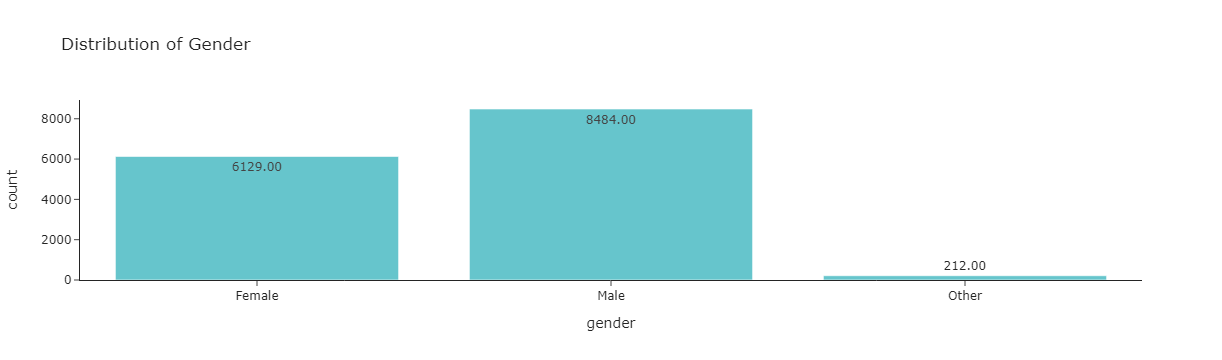

In [130]:
#Plotting the distribution of gender
label =profile['gender'].value_counts()
px.histogram(profile, x= 'gender',color_discrete_sequence = color, labels = label, text_auto='.2f',
             template = 'simple_white',title='Distribution of Gender')

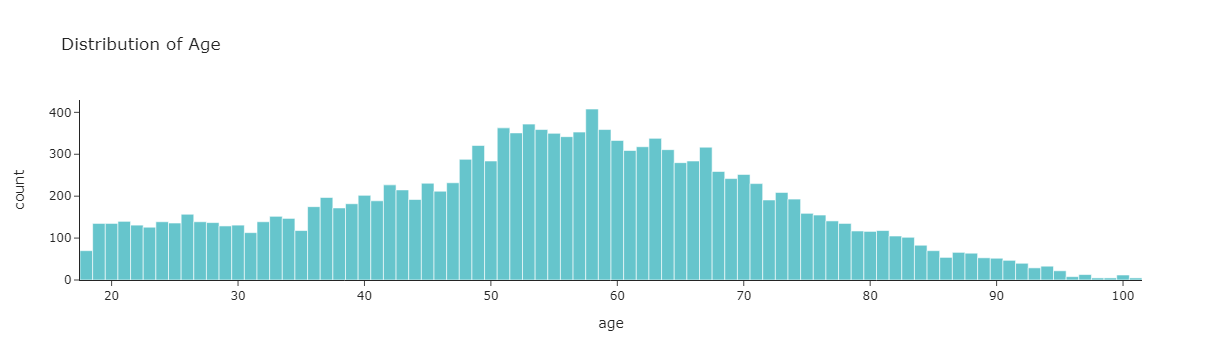

In [133]:
# Plotting the distribution of age
px.histogram(profile, x= 'age',color_discrete_sequence=px.colors.qualitative.Pastel,
             template = 'simple_white',title='Distribution of Age')

In [23]:
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [24]:
profile['age'].value_counts()

58.0     408
53.0     372
51.0     363
59.0     359
54.0     359
        ... 
100.0     12
96.0       8
98.0       5
101.0      5
99.0       5
Name: age, Length: 84, dtype: int64

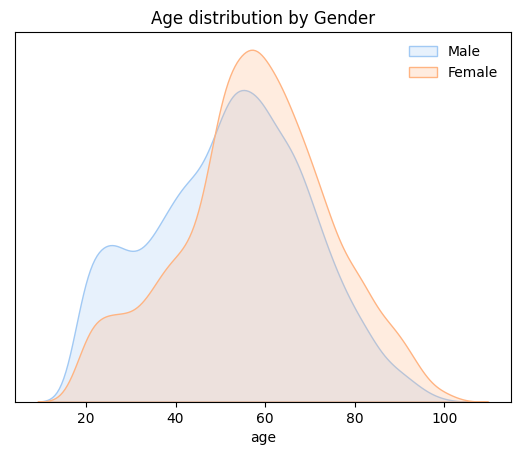

In [25]:
sns.kdeplot(profile[profile['gender']=='Male']['age'],fill=True);
sns.kdeplot(profile[profile['gender']=='Female']['age'],fill=True);
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);

In [26]:
# getting a quick look on the profile data of customers registered at age =118 
print(df_118.head())
print('1-The shape of this dataframe is' ,df_118.shape)
print('2-The number of null values in the "gender" column is:', df_118['gender'].isnull().sum())
print('3-The number of null values in the "income" column is:', df_118['income'].isnull().sum())

  gender  income  age
0   None     NaN  118
2   None     NaN  118
4   None     NaN  118
6   None     NaN  118
7   None     NaN  118
1-The shape of this dataframe is (2175, 3)
2-The number of null values in the "gender" column is: 2175
3-The number of null values in the "income" column is: 2175


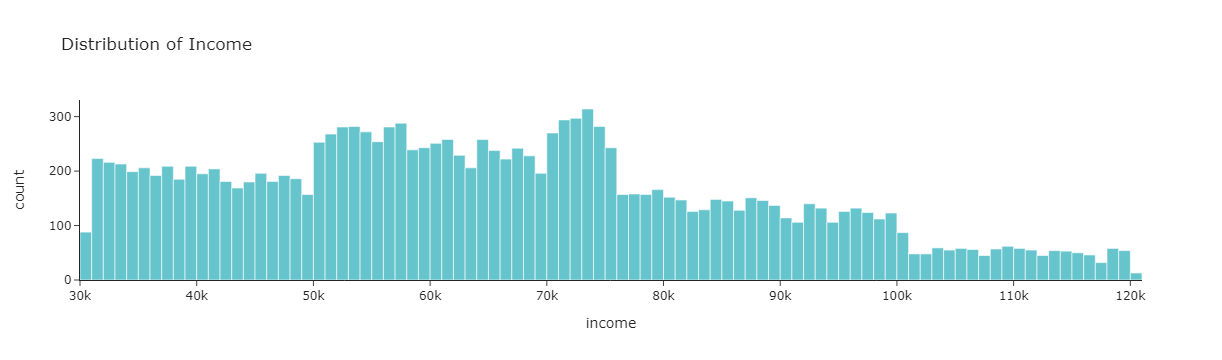

In [132]:
# Plotting the distribution of income
px.histogram(profile, x= 'income',color_discrete_sequence=px.colors.qualitative.Pastel,
             template = 'simple_white',title='Distribution of Income')

In [28]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

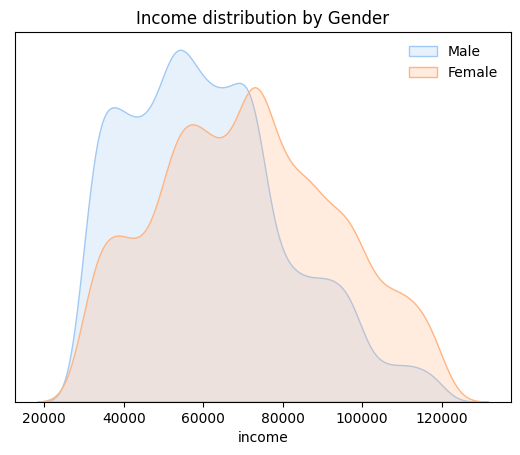

In [29]:
sns.kdeplot(profile[profile['gender']=='Male']['income'],fill=True);
sns.kdeplot(profile[profile['gender']=='Female']['income'],fill=True);
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);

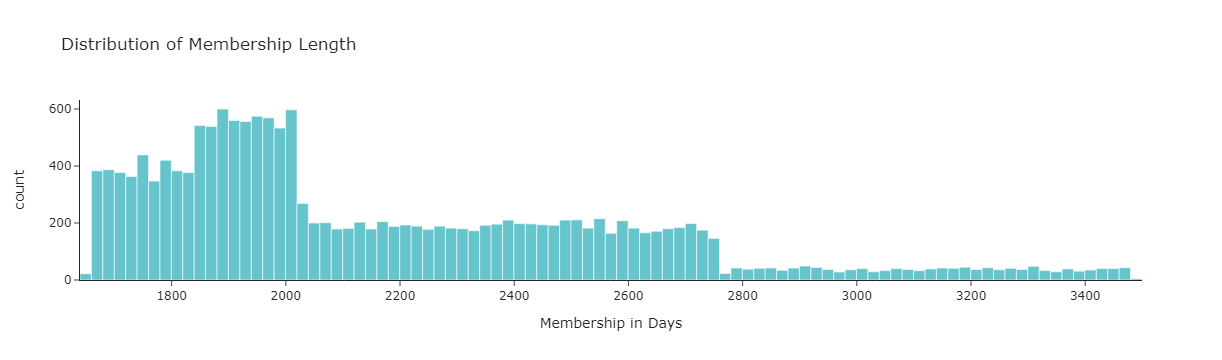

In [131]:
# Plotting the distribution of income
px.histogram(profile, x= 'became_member_on',color_discrete_sequence=px.colors.qualitative.Pastel,
             template = 'simple_white',title='Distribution of Membership Length', labels = dict(became_member_on='Membership in Days'))

In [31]:
# getting a quick look on the profile data of customers registered at age =118 
print(df_118.head())
print('1-The shape of this dataframe is' ,df_118.shape)
print('2-The number of null values in the "gender" column is:', df_118['gender'].isnull().sum())
print('3-The number of null values in the "income" column is:', df_118['income'].isnull().sum())

  gender  income  age
0   None     NaN  118
2   None     NaN  118
4   None     NaN  118
6   None     NaN  118
7   None     NaN  118
1-The shape of this dataframe is (2175, 3)
2-The number of null values in the "gender" column is: 2175
3-The number of null values in the "income" column is: 2175


### Findings from the exploratory analysis of the profile dataset

* The dataset has 5 columns and 17,000 rows.
* The dataset has no duplicated rows.
* The dataset has 2175 missing values on each of: ‘gender’, ’income’ variables.
* The customers ages range from 18 to 101. Although that 2175 customers were registered at age 118 but I stilI considered this specific age an outlier b/c it appears clearly that there is something wrong related with these 2175 rows in the dataset.
* Exploring and visualizing three variables in this dataset: ‘gender’,’income’ and ’age’, allowed me to get the following conclusion:
    * The missing values in 'gender' and ‘income’ variables which are are related solely and specifically with the 2175 customers registered at age 118. In other words, customers at age 118 has no registered ‘gender’ and ‘income’. This needs to be cleaned in the Data Preprocessing (Wrangling/Cleaning) Section.
    * Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
    * According to the available data, There are three ‘gender’ categories into which the customers falls in ( M, F and O). Keeping in our mind the above observation that there are 2175 missing values, Male Customers (8484 men) are more than Female Customers(6129 women) with 57% of customers are Males compared to 41% Females. However, there are 212 customers chose “O” as their gender.

---

### 3. Transcript

In [32]:
def clean_transcript(transcript):
    
    #Extract offer_id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    
    #create two seperate columns for reward and amount
    
    for i in ['reward','amount']:
        transcript[i] = transcript['value'].apply(lambda x:x[i] if i in x else None)
    
    transcript.drop('value',axis=1,inplace=True)
    
    transcript.rename(columns={'person':'customer_id'},inplace=True)
    
    #Convert transcript time from hours to days
    transcript['time'] = transcript['time'] / 24
    
    return transcript
transcript = clean_transcript(transcript)

In [33]:
transcript.head()

customer_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   0.0   
1  a03223e636434f42ac4c3df47e8bac43  offer received   0.0   
2  e2127556f4f64592b11af22de27a7932  offer received   0.0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   0.0   
4  68617ca6246f4fbc85e91a2a49552598  offer received   0.0   

                           offer_id  reward  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN     NaN

In [34]:
# checking the number of rows and columns of the dataset
transcript.shape

(306534, 6)

In [35]:
# checking the columns' titles and datatypes 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  306534 non-null  object 
 1   event        306534 non-null  object 
 2   time         306534 non-null  float64
 3   offer_id     167581 non-null  object 
 4   reward       33579 non-null   float64
 5   amount       138953 non-null  float64
dtypes: float64(3), object(3)
memory usage: 14.0+ MB


In [36]:
# checking for duplicates
transcript.columns.duplicated().sum()

0

In [37]:
# checking for the existence of missing values(NaNs)
transcript.isna().sum()

customer_id         0
event               0
time                0
offer_id       138953
reward         272955
amount         167581
dtype: int64

In [38]:
# getting the types of events of the transcripts 
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [39]:
# checking the count of each event type
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [40]:
# creating a dataframe to include ONLY the 'transaction' event
df_transaction = transcript[transcript['event'] == 'transaction']

### Findings of the exploratory analysis of transcript

* The dataset has 4 columns and 306,534 rows.
* The dataset has no duplicated rows and no missing values.
* The ‘value’ column is a dictionary that contains offer id's for all events except the transaction. We can apply some kind of Feature Engineering to extract useful data that would surely contribute in the success of our future model. This step will be done through the Data Preprocessing (Wrangling/Cleaning) Section.
* There are four types of events in this dataset: ‘transaction’, ’ offer received’, ‘offer viewed’ and ‘offer completed’.
* All the events that are classified as ‘transaction’ do not have an ‘offerid’ within its ‘value’ column. Therefore these are probably transactions made without any offer or reward. This might be useful to analyse what customers would by anyways and don't need to get special offers.

---

### 4. Overall Dataframe

In [41]:
def transform_transcript(transcript):
    '''
    Function to transform transcript dataframe to return a dataframe where it shows each successful and unsuccesful offer.
    
    Input - Transcript dataframe 
    
    Output - transformed transcript dataframe
     
    '''
    
    offer_customer = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    
    offer_customer.reset_index(level=[0,1],inplace = True)
    
    #Replace nan values with 0.0
    
    offer_customer.fillna(0.0, inplace = True)
    
    #Need to determine which offers where successful - where offer completed and offer viewed  are greater than 1.
    
    #We can multiply the two columns together and replace any values > 0 with 1.
    
    #This is an important step as some offers are completed but have not been viewed - meaning the offer did not cause the 
    #transaction.
    
    offer_customer['successful offer'] = offer_customer['offer completed'] * offer_customer['offer viewed']
    
    offer_customer['successful offer'] = offer_customer['successful offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
    offer_customer.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)
                                                        
                
    return offer_customer

transcript = transform_transcript(transcript)

In [42]:
def merge_dataframes(profile,portfolio,transcript):
    
    '''
    Function to merge all the dataframes together.
    
    Input - profile, portfolio and transcript dataframes
    
    Output - single dataframe
    
    '''
    
    overall = transcript.merge(portfolio,how='left',on='offer_id')
    
    overall = overall.merge(profile,how='left',on='customer_id')
    
    
    return overall


overall_df = merge_dataframes(profile,portfolio,transcript)

overall_df.head()

customer_id                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5   
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
3  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   
4  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4   

   successful offer  reward  difficulty  duration  email  mobile  social  web  \
0               0.0       2          10         7      1       1       0    1   
1               0.0       0           0         4      1       1       0    1   
2               0.0       0           0         3      1       1       1    0   
3               1.0       5           5         5      1       1       1    1   
4               1.0       2          10        10      1       1       1    1   

   offer_type-bogo  offer_type-discount  offer_type-informational gender  \
0                0                    1                         0   Male   
1                0                    0                         1   Male   
2                0                    0                         1   Male   
3                1                    0                         0   Male   
4                0                    1                         0   Male   

    age  became_member_on   income  gender-Female  gender-Male  gender-Other  
0  33.0            2120.0  72000.0              0            1             0  
1  33.0            2120.0  72000.0              0            1             0  
2  33.0            2120.0  72000.0              0            1             0  
3  33.0            2120.0  72000.0              0            1             0  
4  33.0            2120.0  72000.0              0            1             0

The result is a single dataframe which includes information about the offer and information about the customer for every combination of offers and customers.

We also determined whether an offer was successful - which was when an offer was completed and viewed by the customer.

In [43]:
def change_offer_id(overall_df):
    
    '''
    Funtion to change the offer ids into a more readable form e.g offer 1, offer 2.
    
    Input - overall_df which is the combined dataframe from all 3 datasets.
    
    Output - overall_df with altered offer ids.
    
    '''
    
    unique_ids = list(overall_df['offer_id'].unique())
    
    for i in range(len(unique_ids)):
        
        overall_df['offer_id'] = overall_df['offer_id'].apply(lambda x: f'Offer {i+1}' if x == unique_ids[i] else x)
        
            
    return overall_df
            
overall_df = change_offer_id(overall_df)
overall_df.head()

customer_id offer_id  successful offer  reward  \
0  0009655768c64bdeb2e877511632db8f  Offer 1               0.0       2   
1  0009655768c64bdeb2e877511632db8f  Offer 2               0.0       0   
2  0009655768c64bdeb2e877511632db8f  Offer 3               0.0       0   
3  0009655768c64bdeb2e877511632db8f  Offer 4               1.0       5   
4  0009655768c64bdeb2e877511632db8f  Offer 5               1.0       2   

   difficulty  duration  email  mobile  social  web  offer_type-bogo  \
0          10         7      1       1       0    1                0   
1           0         4      1       1       0    1                0   
2           0         3      1       1       1    0                0   
3           5         5      1       1       1    1                1   
4          10        10      1       1       1    1                0   

   offer_type-discount  offer_type-informational gender   age  \
0                    1                         0   Male  33.0   
1                    0                         1   Male  33.0   
2                    0                         1   Male  33.0   
3                    0                         0   Male  33.0   
4                    1                         0   Male  33.0   

   became_member_on   income  gender-Female  gender-Male  gender-Other  
0            2120.0  72000.0              0            1             0  
1            2120.0  72000.0              0            1             0  
2            2120.0  72000.0              0            1             0  
3            2120.0  72000.0              0            1             0  
4            2120.0  72000.0              0            1             0

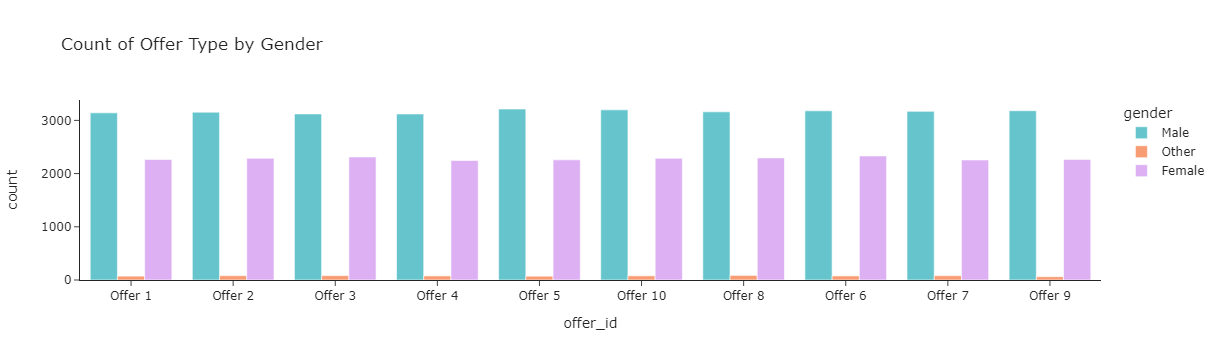

In [44]:
# Plot the count of offer type by gender

px.histogram(overall_df, x='offer_id', color='gender', color_discrete_sequence=px.colors.qualitative.Pastel, barmode= 'group',
             template = 'simple_white',title='Count of Offer Type by Gender')

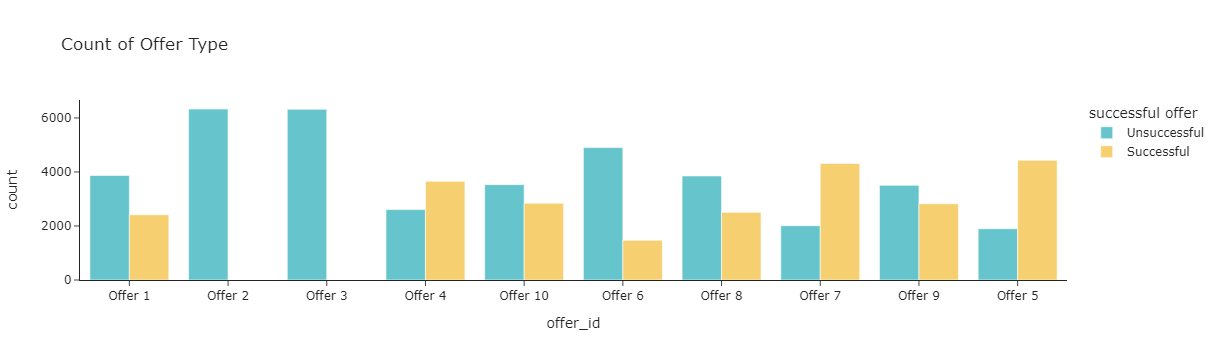

In [45]:
# Plot the count of succesful and unsuccesful offers


# Replace values in Successful Offer column for a better understanding in the plot
overall_success = overall_df.replace({'successful offer' : {0.0: 'Unsuccessful', 1.0: 'Successful'}})

px.histogram(overall_success, x='offer_id', color='successful offer', color_discrete_sequence=px.colors.qualitative.Pastel, barmode= 'group',
             template = 'simple_white',title='Count of Offer Type')

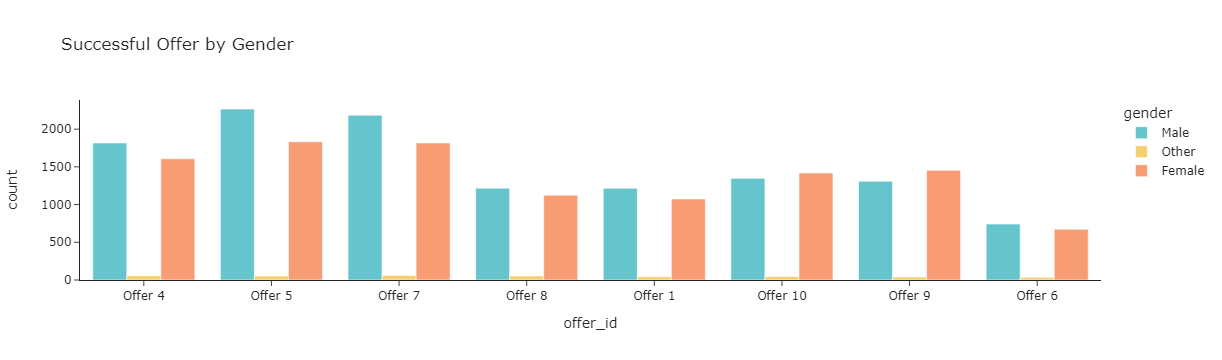

In [134]:
# Plot the count of succesful offers by gender

successful = overall_df.loc[overall_df['successful offer']==1]
px.histogram(successful, x='offer_id', color='gender', color_discrete_sequence=px.colors.qualitative.Pastel, barmode= 'group',
             template = 'simple_white',title='Successful Offer by Gender')

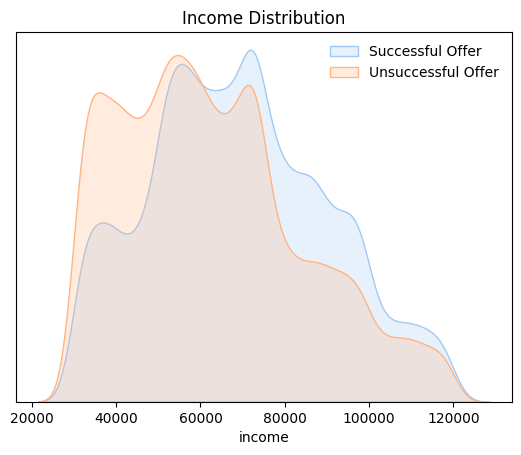

In [47]:
#Distribution of income whether offer was successful
sns.set_palette('pastel')
sns.kdeplot(overall_df.loc[overall_df['successful offer'] == 1]['income'], fill=True)
sns.kdeplot(overall_df.loc[overall_df['successful offer'] == 0]['income'],fill=True)
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Income Distribution');

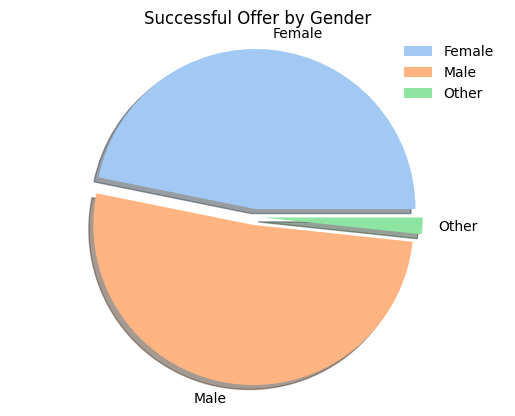

In [48]:
# Plotting the distribution of gender for successful offers

success_grouped = overall_df.groupby(['gender'])['successful offer'].sum()

plt.pie(success_grouped, labels = success_grouped.index,shadow=True,explode = (0.05,0.05,0.05));
plt.legend(['Female','Male','Other'],frameon=False)
plt.title("Successful Offer by Gender")

plt.gca().axis('Equal');

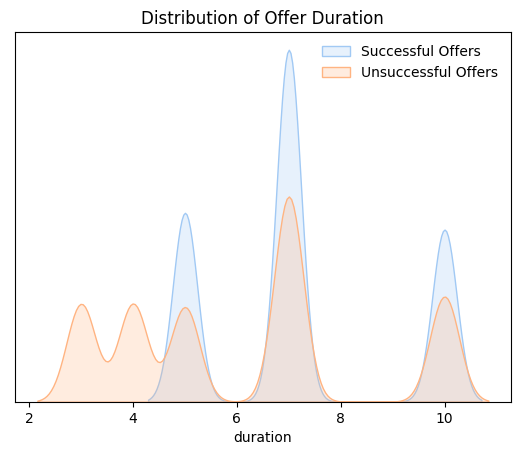

In [49]:
# Plotting the distribution of duration for the offers

sns.kdeplot(overall_df[overall_df['successful offer']==1]['duration'], fill=True);
sns.kdeplot(overall_df[overall_df['successful offer']==0]['duration'], fill=True)            
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution of Offer Duration')
plt.gca().get_yaxis().set_visible(False);

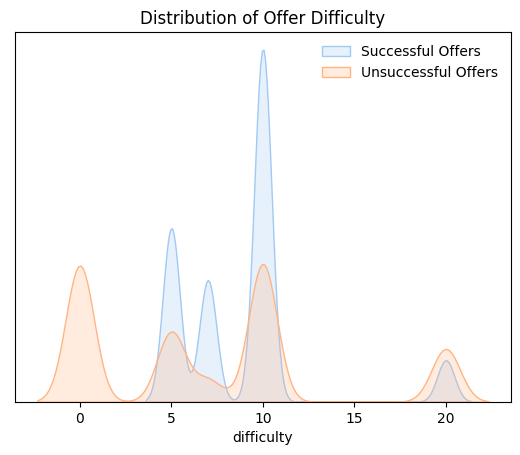

In [50]:
# Plotting the distribution of difficulty for the Offers

sns.kdeplot(overall_df[overall_df['successful offer']==1]['difficulty'],fill=True);
sns.kdeplot(overall_df[overall_df['successful offer']==0]['difficulty'],fill=True)
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution of Offer Difficulty')
plt.gca().get_yaxis().set_visible(False);

---

# Modelling

After some exploratory analysis on the different datasets and a merged dataframe, we can now try different models to predict which offer would be best suited for each customer.

---

### Predict whether a customer offer combination will be successful

Here we are now going to predict whether a user will complete an offer based on variables from the user and on the offer.

I will be using Random Forest Classifier, Logistic Regression, SVM, LDA and Adaboost to try and predict whether a customer receiving an offer will be successful.

To evaluate these models i will be using the model accuracy, the f1 score and the AUC rating. As i care equally about how the model classifies both classes i will place more of a preference on the accuracy. However, if i cared more about incorrectly classified predictions i would have chosen to focus on the f1 score. To visualize the performance of the models i will use Confusion matrixs and AUC curves.

---

### 1. Random Forest Classifier

The first Model that will be used is a Random Forest Classiefier to choose the offer type that would be best received by the customer

In [51]:
def clean_overall_df(overall_df):
    '''
    Function to clean overall_df to return X variables and the predictor Y
    
    Input - overall_df
    
    output - two dataframes X and Y
    
    X - Will be all the variables we will be using to predict the best offer type.
    
    Y - Will be the offer type.
    
    '''
    
    #We want to look at only successful offers
    
    clean_df_ = overall_df.loc[overall_df['successful offer'] == 1]
    

    
    clean_df_.drop('gender',axis=1,inplace = True)
    
    #We have missing values in income and age - fill these with the means for that column.
    
    for col in ['age','income']:
        
        clean_df_[col] = clean_df_[col].fillna(clean_df_[col].mean())
    
    
    
    
    X = clean_df_.iloc[:,3:]
    
    Y= clean_df_.iloc[:,1]
    
    
    return X, Y

X,Y = clean_overall_df(overall_df)
    
    
X.shape, Y.shape
    

((24460, 16), (24460,))

Now we have the training and test data sets we need to ensure that there are no missing values.



In [52]:
overall_df.isnull().sum()
X.isnull().sum()

reward                      0
difficulty                  0
duration                    0
email                       0
mobile                      0
social                      0
web                         0
offer_type-bogo             0
offer_type-discount         0
offer_type-informational    0
age                         0
became_member_on            0
income                      0
gender-Female               0
gender-Male                 0
gender-Other                0
dtype: int64

In [53]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.25,random_state=21)
X_train.shape,X_test.shape

((18345, 16), (6115, 16))

In [54]:
#Feature scaling
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [55]:
clf = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=42)

clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [56]:
y_pred = clf.predict(X_test)

In [57]:
confusion = confusion_matrix(y_test,y_pred)

In [58]:
accuracy_score(y_test,y_pred)

1.0

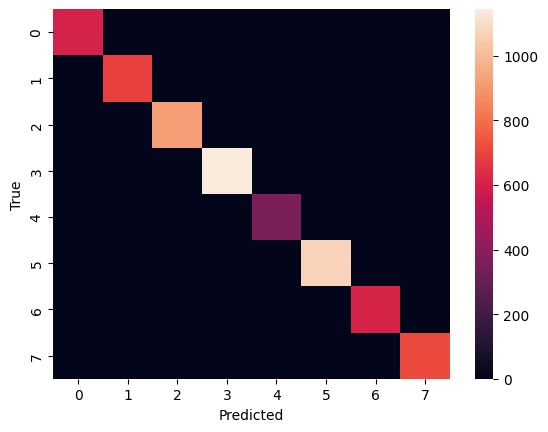

In [59]:
sns.heatmap(confusion)
plt.ylabel('True')
plt.xlabel('Predicted');

In the X dataframe used to train this model i included information about the actual offer e.g difficulty and duration. This could explains why the classfication accuracy has a perfect score. This is not useful as we want to be able to predict which offer would be successful using information about the customer alone.

In [60]:
X,Y = clean_overall_df(overall_df)

#Only keep inforamtion in the X dataframe that refers to the user.
X = X.iloc[:,10:]
X.head()

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2,random_state=21)

#Feature Scaling

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Instansiate Classifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=42)


#Train Classifier
clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [61]:
y_pred = clf.predict(X_test)

print('Model accuracy: {0:0.4f}'.format(accuracy_score(y_test,y_pred)))

Model accuracy: 0.0656


In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Offer 1       0.03      0.02      0.02       487
    Offer 10       0.03      0.03      0.03       554
     Offer 4       0.05      0.05      0.05       737
     Offer 5       0.12      0.12      0.12       909
     Offer 6       0.01      0.01      0.01       285
     Offer 7       0.11      0.12      0.11       864
     Offer 8       0.04      0.04      0.04       485
     Offer 9       0.04      0.04      0.04       571

    accuracy                           0.07      4892
   macro avg       0.05      0.05      0.05      4892
weighted avg       0.06      0.07      0.06      4892



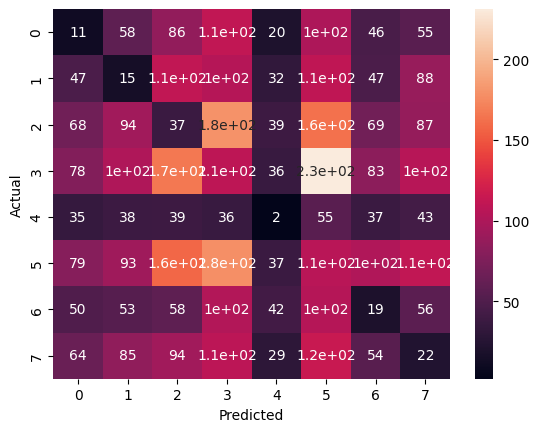

In [63]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True);
plt.xlabel("Predicted")
plt.ylabel("Actual");

The model has a very low accuracy and very low f1-scores for the offers. The linear regression model is not useful as a model to forecast which offer a customer might like.

---

### 2. Logistic Regression

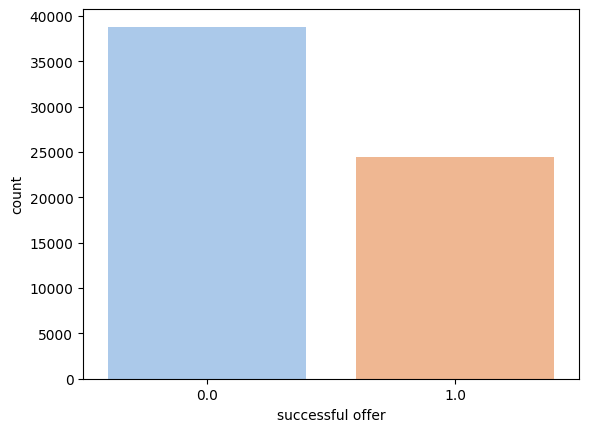

In [64]:
sns.countplot(overall_df, x='successful offer');

There is an imbalance between the classes which woul affect the logistic regression model. Therefore datapoints for the successful offer will be randomly sampeled until the classes are even.

In [65]:
df_class1 = overall_df.loc[overall_df['successful offer']==1]

In [66]:
count_class0,count_class1 = overall_df['successful offer'].value_counts()

In [67]:
df_class1_over = df_class1.sample(count_class0,replace=True)

df_class_0 = overall_df.loc[overall_df['successful offer'] == 0]

over_df = pd.concat([df_class1_over,df_class_0],axis=0)

# over_df now has balanced classifying classes
over_df.drop('gender',axis=1,inplace=True)

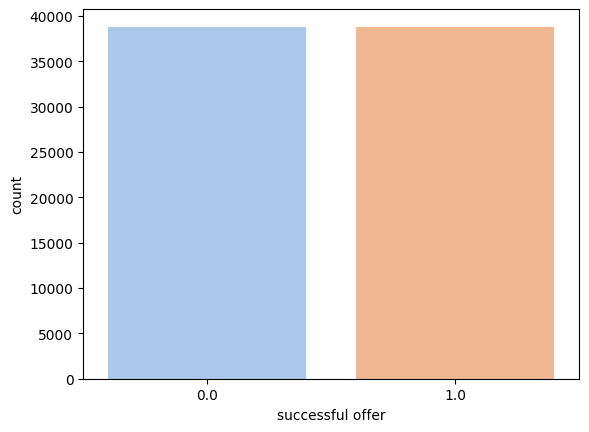

In [68]:
sns.countplot(over_df, x='successful offer');

With the classes now balanced, missing values in the age and income columns need to be filled. In the exploratory analysis I identified a light right skew in both distributions. Therefore the missing values will be filled with the median.

During the initial cleaning i have already encoded the catergorical variables like gender etc.

A key assumption for Logistic Regression is that there is little or no multicolinearlity between independent variables.

In regards to outliers from my research i have read that Logistic Regression is robust in regards to outliers due to an inverse logistic loss function.

To process the data we will use MinMaxScaler.

In [69]:
over_df.isnull().sum()

#Impute missing values with median value for the column. I have chosen the median because both age and income have
#a right skew in their distributions.
for col in ['age','income']:
    over_df[col] = over_df[col].fillna(over_df[col].median())

In [70]:
X = over_df.iloc[:,3:]
y = over_df.iloc[:,2]

X = pd.concat([X, over_df['offer_id']],axis=1)

def encode_offer_id(X):
    
    '''
    Fuction to encode offer id into dummy columns.
    
    Input - X dataframe with offer_id column present
    
    Output - X dataframe with encoded columns for offer id
    
    '''
    
    dummies = pd.get_dummies(X['offer_id'])
    
    new = pd.concat([X.drop('offer_id',axis=1), dummies],axis=1)
    
    
    return new

X = encode_offer_id(X)

X.columns

Index(['reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web',
       'offer_type-bogo', 'offer_type-discount', 'offer_type-informational',
       'age', 'became_member_on', 'income', 'gender-Female', 'gender-Male',
       'gender-Other', 'Offer 1', 'Offer 10', 'Offer 2', 'Offer 3', 'Offer 4',
       'Offer 5', 'Offer 6', 'Offer 7', 'Offer 8', 'Offer 9'],
      dtype='object')

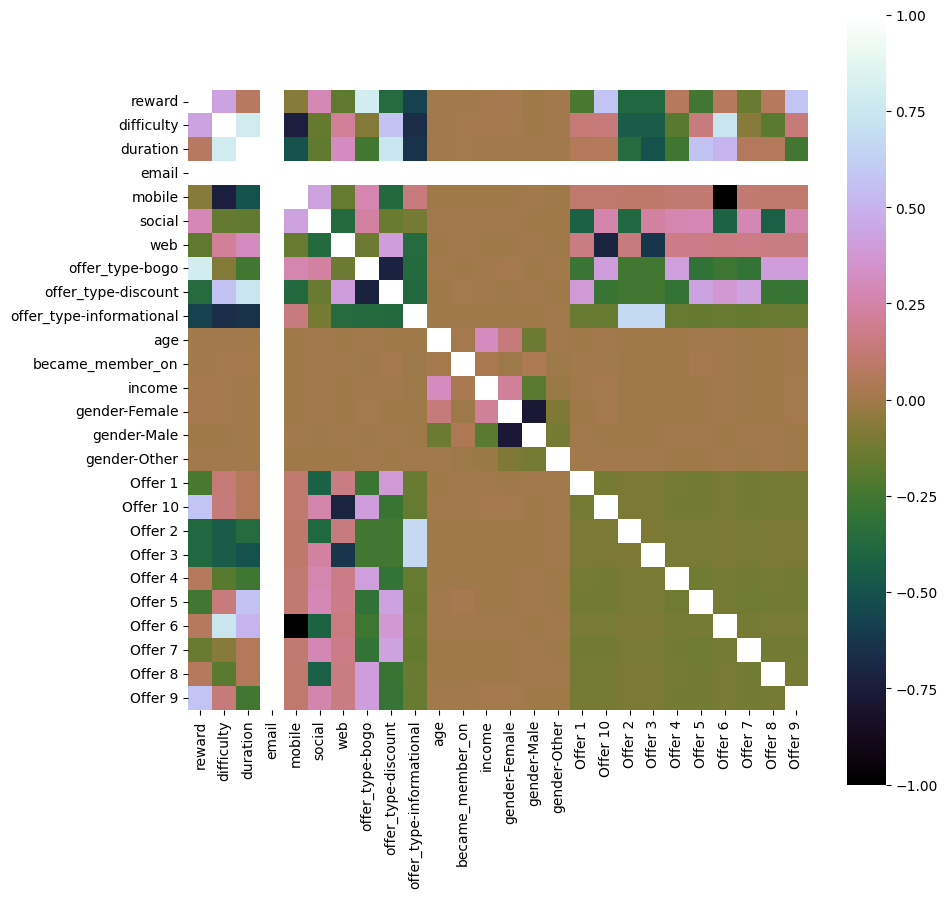

In [71]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),square=True, cmap='cubehelix');

As Logistic Regression assumes little or no multicolinearity i am going to drop the email feature as it appears to be strongly correlated with every feature.

In [72]:
X_log = X.drop(['email'],axis=1)

In [73]:
# Train-test split and fitting the MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X_log,y,test_size=.2, random_state = 42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

In [74]:
# initiating the model
model = LogisticRegression(solver='liblinear',random_state=42)

In [75]:
# Fitting the model
model.fit(X_train,y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [76]:
log_pred = model.predict(X_test)

In [77]:
log_accuracy = accuracy_score(y_test,log_pred)

print("Logistic Regression Accuracy: %.4f" % accuracy_score(y_test, log_pred))

Logistic Regression Accuracy: 0.7586


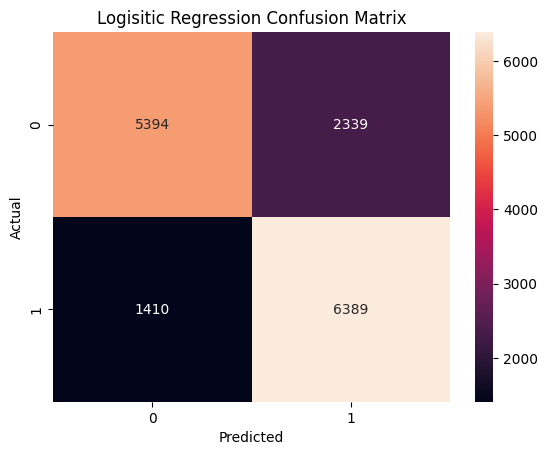

In [78]:
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='d')
plt.title('Logisitic Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

In [79]:
log_f1_score = f1_score(y_test,log_pred)

print('Logisitic Regression F1 Score: %.4f' % log_f1_score)

Logisitic Regression F1 Score: 0.7732


The logistic regression model has an accuracy of 75.86% and an f1-score of 0.7732.  Since this is a binary classification I will place more weight on the f1-score, since it is the harmonic mean of recall and precision.

In the next step I will try to optimize the model using GridSearchCV.

In [80]:
parameters = {'penalty': ['l1','l2'], 'C': [1,10,100,1000], 'solver' : ['liblinear']}

grid_log = GridSearchCV(LogisticRegression(), parameters, verbose=3,cv=3)

In [81]:
grid_log.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END .C=1, penalty=l1, solver=liblinear;, score=0.761 total time=  11.0s
[CV 2/3] END .C=1, penalty=l1, solver=liblinear;, score=0.765 total time=  11.4s
[CV 3/3] END .C=1, penalty=l1, solver=liblinear;, score=0.759 total time=  11.7s
[CV 1/3] END .C=1, penalty=l2, solver=liblinear;, score=0.761 total time=   0.1s
[CV 2/3] END .C=1, penalty=l2, solver=liblinear;, score=0.765 total time=   0.1s
[CV 3/3] END .C=1, penalty=l2, solver=liblinear;, score=0.759 total time=   0.1s
[CV 1/3] END C=10, penalty=l1, solver=liblinear;, score=0.761 total time=   0.0s
[CV 2/3] END C=10, penalty=l1, solver=liblinear;, score=0.765 total time=   0.0s
[CV 3/3] END C=10, penalty=l1, solver=liblinear;, score=0.759 total time=   0.0s
[CV 1/3] END C=10, penalty=l2, solver=liblinear;, score=0.761 total time=   0.1s
[CV 2/3] END C=10, penalty=l2, solver=liblinear;, score=0.765 total time=   0.2s
[CV 3/3] END C=10, penalty=l2, solver=liblinear;,

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             verbose=3)

In [82]:
grid_log.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

In [83]:
log2_pred = grid_log.predict(X_test)

In [84]:
log2_accuracy = accuracy_score(y_test,log2_pred)
log2_f1 = f1_score(y_test,log2_pred)

In [85]:
print('Tuned Logistic Regression accuracy: %.4f' % log2_accuracy)
print('Tuned Logistic Regression F1 score: %.4f' % log2_f1)

Tuned Logistic Regression accuracy: 0.7586
Tuned Logistic Regression F1 score: 0.7732


In [86]:
log_fpr,log_tpr,log_thresholds = roc_curve(y_test,log_pred)
log_auc = auc(log_fpr,log_tpr)

In [87]:
log2_fpr,log2_tpr,log2_thresholds = roc_curve(y_test,log2_pred)
log2_auc = auc(log2_fpr,log2_tpr)

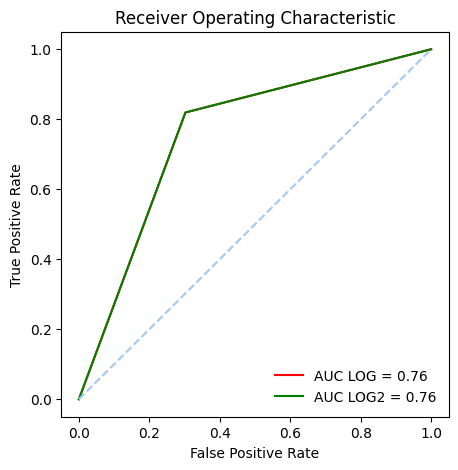

In [88]:
#Plot the auc 
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(log_fpr,log_tpr, color='red',label = 'AUC LOG = %0.2f' % log_auc)
plt.plot(log2_fpr,log2_tpr,color='green',label = 'AUC LOG2 = %0.2f' % log2_auc)
plt.legend(loc = 'lower right',frameon=False)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

Using GridSearch did not improve the accuracy or the f1-score.

---

### 3. Support Vector Machines (SVM)

For SVM we need to further process the data. Its important that the data is scaled to avoid difficulties in the kernel calculation.

SVM's are great for non linear classification problems.

As using GridSearch will take too long using SVM i will change the kernel and the regularization parameter C to try and optimize the classifier.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=.2)

#Feature scaling
scaler = StandardScaler()

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

To begin with i will use the Linear kernel and the default parameter for C, which is 1.

In [90]:
svc = SVC(kernel='linear')

#Train model
svc.fit(X_train,y_train)

#Predict values from test dataset
svc_y_pred = svc.predict(X_test)

#Evaluate accuracy and f1 score
svc_accuracy = accuracy_score(y_test,svc_y_pred)
svc_f1 = f1_score(y_test,svc_y_pred)

In [91]:
print('SVC Model Accuracy: %.4f' % svc_accuracy)
print('SVC F1 Score: %.4f' % svc_f1)

SVC Model Accuracy: 0.7361
SVC F1 Score: 0.7740


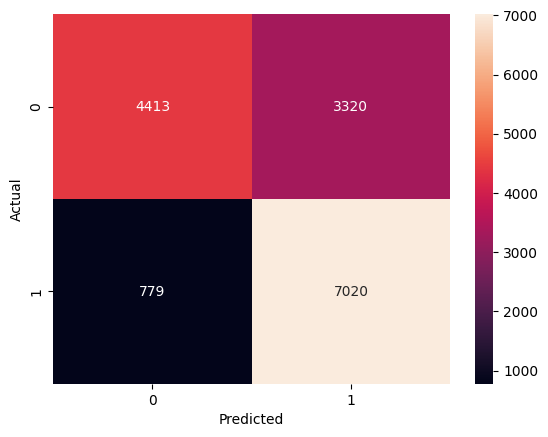

In [92]:
sns.heatmap(confusion_matrix(y_test,svc_y_pred),annot=True,fmt='d');
plt.ylabel("Actual")
plt.xlabel("Predicted");

In [93]:
print(classification_report(y_test,svc_y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.57      0.68      7733
         1.0       0.68      0.90      0.77      7799

    accuracy                           0.74     15532
   macro avg       0.76      0.74      0.73     15532
weighted avg       0.76      0.74      0.73     15532



Since a linear Kernel was used, I can view the coefficients for each variable

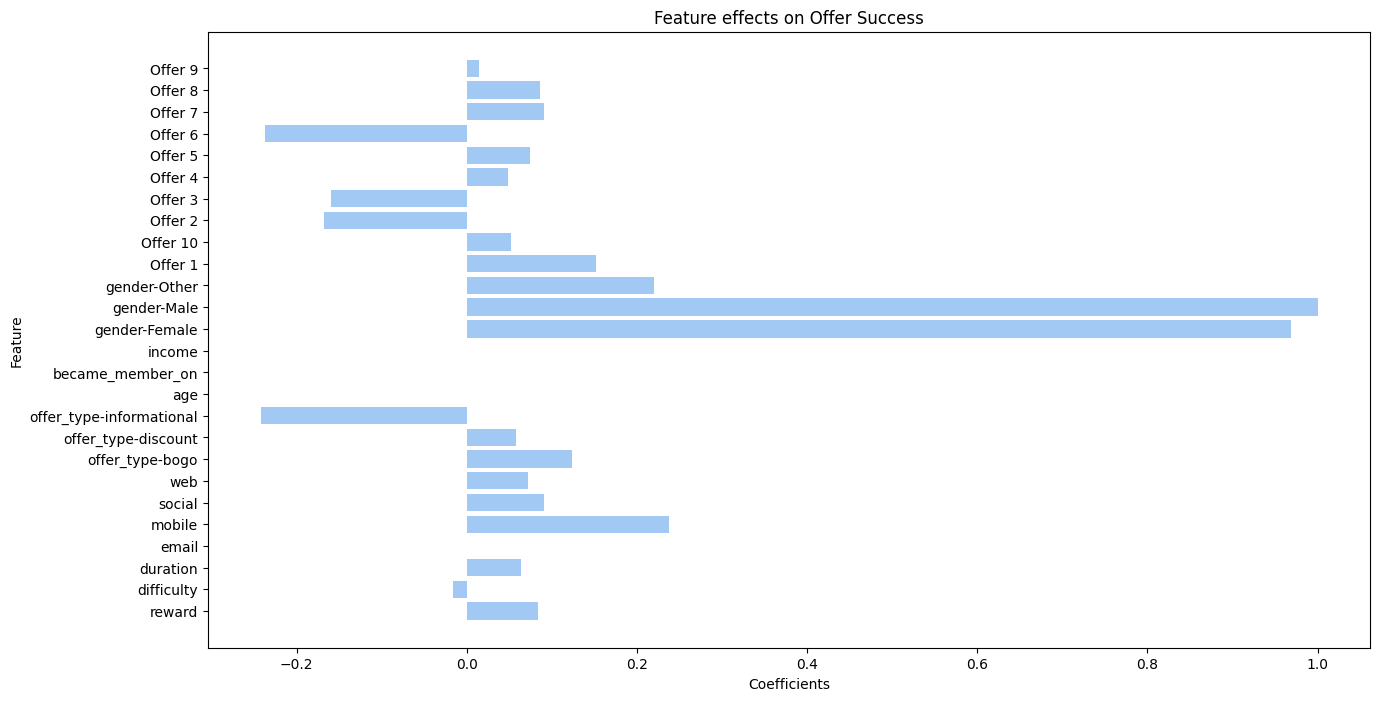

In [94]:
#Create a plot of the coefficients for a given feature.

feature_names = list(X.columns)
coefs = list(svc.coef_[0])

plt.figure(figsize=(15,8))
plt.barh(feature_names,coefs)
plt.title('Feature effects on Offer Success')
plt.xlabel('Coefficients')
plt.ylabel('Feature');

Now i will change the kernel function to Radial Basic Function.



In [95]:
svc_model = SVC(C=1,gamma=1,kernel='rbf')

svc_model.fit(X_train,y_train)

SVC(C=1, gamma=1)

In [96]:
y_pred_svc_2 = svc_model.predict(X_test)
svc2_accuracy = accuracy_score(y_test,y_pred_svc_2)
svc2_f1 = f1_score(y_test,y_pred_svc_2)

In [97]:
print('Accuracy for SVM with RBF Kernel: %.4f' % svc2_accuracy)
print('F1 score for SVM with RBF Kernel: %.4f' % svc2_f1)

Accuracy for SVM with RBF Kernel: 0.7789
F1 score for SVM with RBF Kernel: 0.7929


In [98]:
print(classification_report(y_test,y_pred_svc_2))

              precision    recall  f1-score   support

         0.0       0.82      0.71      0.76      7733
         1.0       0.75      0.84      0.79      7799

    accuracy                           0.78     15532
   macro avg       0.78      0.78      0.78     15532
weighted avg       0.78      0.78      0.78     15532



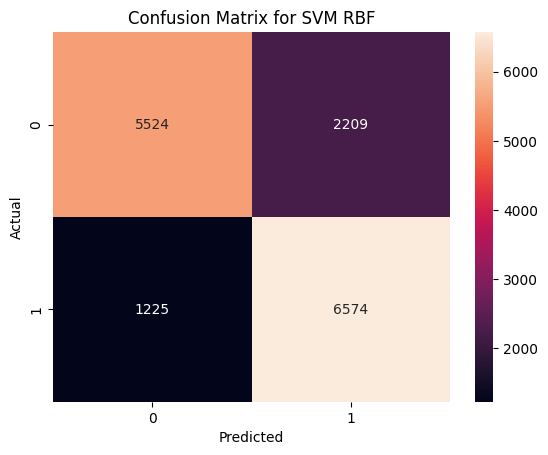

In [99]:
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test,y_pred_svc_2)

sns.heatmap(confusion_matrix(y_test,y_pred_svc_2),annot=True,fmt='d')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for SVM RBF");

In [100]:
#Area under curve
roc_auc = auc(svc_fpr,svc_tpr)
roc_auc


0.7786348579905109

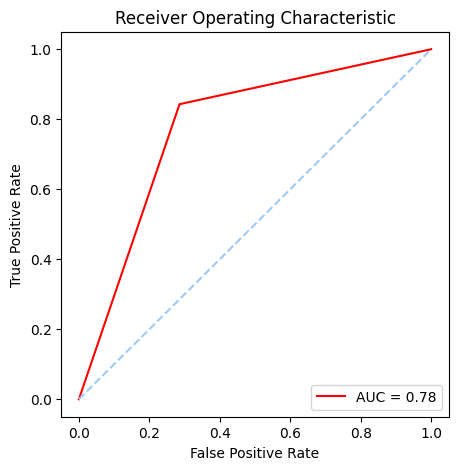

In [101]:
#Plot the auc 
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(svc_fpr,svc_tpr, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

With an AUC of 0.79 the SVM model is doing quite well at distinguishing wether an offer is successful or unsuccessful. It achieved an accuracy of 78.59% and a f1-score of 0.7998.

The Radial Basic Function performed better than the Linear Kernel.
By Changing the parameter C to 100 I will try to further improve the model.

In [102]:
svc3 = SVC(C=100,gamma=1,kernel='rbf',cache_size=600)

svc3.fit(X_train,y_train)

svc3_y = svc3.predict(X_test)

In [103]:
svc3_accuracy = accuracy_score(y_test,svc3_y)
svc3_f1_score = f1_score(y_test,svc3_y)


print('SVC RBF Model with C = 100 Accuracy: %.4f' % svc3_accuracy)
print('SVC RBF Model with C = 100 F1 Score: %.4f' % svc3_f1_score)

SVC RBF Model with C = 100 Accuracy: 0.7863
SVC RBF Model with C = 100 F1 Score: 0.7965


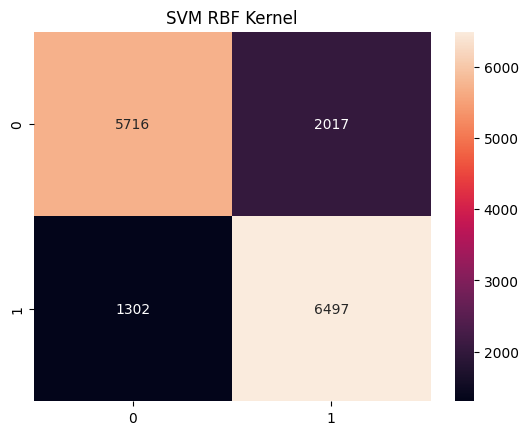

In [104]:
sns.heatmap(confusion_matrix(y_test,svc3_y),annot=True,fmt='d');
plt.title('SVM RBF Kernel');

---

### 4. Linear Discriminant Analysis

I will now try to use Linear Discriminant Analysis to improve on our model accuracy.

LDA is more sensity to outliers than the previous models. I have already examined the age of the user and removed outliers - i now need to look at income and days being a rewards member. I will use the tukey rule to remove any outliers.

LDA assumes normal distribution for features so as a preprocessing step i will normalize the data point

In [105]:
def split_df(over_df):
    '''
    Function to split X, Y from dataframe and split into test and train datasets.
    
    Input - over_df - dataframe with classes balanced.
    
    Output - X_train, X_test, y_train, y_test
    
    '''
    
    for col in ['income','became_member_on']:
        
        #Lower quartile
        Q1 = np.percentile(over_df[col],25)
        
        #Upper quartile
        Q3 = np.percentile(over_df[col],75)
        
        #Calculate interquartile range
        IQR = Q3 - Q1
        
        #Outlier step
        step = IQR * 1.5
        
        #Remove values that are greater than the upper quartile plus 1.5 times the IQR and lower than the lower quartile 
        #minus 1.5 times the IQR (Tukey Rule).
        over_df = over_df[(over_df[col] > (Q1 - step)) & (over_df[col] < (Q3 + step))]
    
    X = over_df.iloc[:,3:]
    
   
    y = over_df.iloc[:,2]
    
    X = pd.concat([X, over_df['offer_id']],axis=1)
    
    dummies = pd.get_dummies(X['offer_id'])
    
    X = pd.concat([X.drop('offer_id',axis=1), dummies],axis=1)
    
    
    
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
    
    return X_train, X_test, y_test, y_train


X_train, X_test, y_test, y_train = split_df(over_df)

X_train = normalize(X_train)
X_test = normalize(X_test)

In [106]:
lda = LinearDiscriminantAnalysis(solver='lsqr')

lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)

In [107]:
y_pred = lda.predict(X_test)
lda_accuracy = accuracy_score(y_test,y_pred)
lda_f1 = f1_score(y_test,y_pred)

print("LDA Model Accuracy: %.4f" % lda_accuracy)
print("LDA Model F1 Accuracy: %.4f" % lda_f1)

LDA Model Accuracy: 0.7591
LDA Model F1 Accuracy: 0.7788


In [108]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.67      0.74      7576
         1.0       0.72      0.85      0.78      7590

    accuracy                           0.76     15166
   macro avg       0.77      0.76      0.76     15166
weighted avg       0.77      0.76      0.76     15166



Text(0.5, 1.0, 'LDA Confusion Matrix')

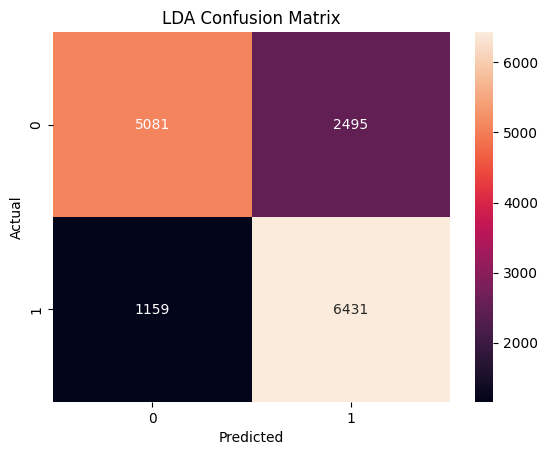

In [109]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('LDA Confusion Matrix')

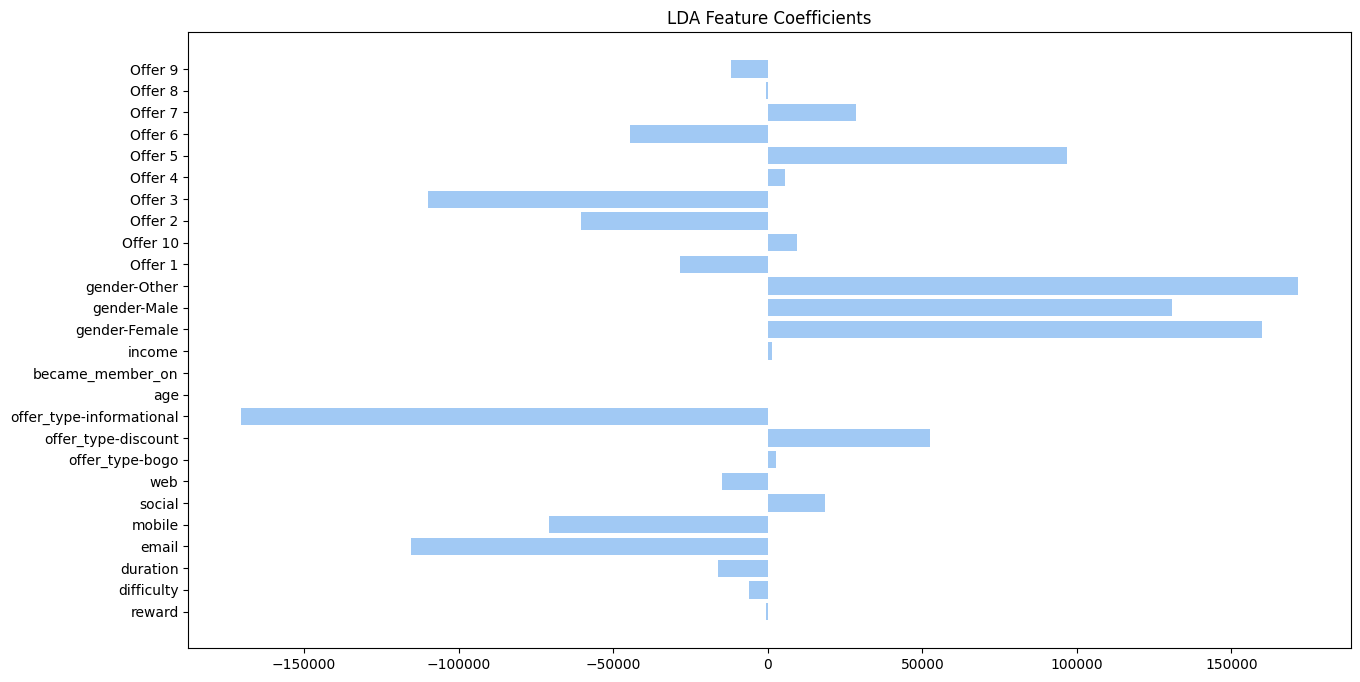

In [110]:
plt.figure(figsize=(15,8))
feature_names = list(X.columns)
coefs = lda.coef_[0]
plt.barh(feature_names,coefs)
plt.title("LDA Feature Coefficients");

In [111]:
lda_fpr,lda_tpr,lda_thresholds = roc_curve(y_test,y_pred)
lda_auc = auc(lda_fpr,lda_tpr)

The LDA model did not perform as well as the SVC model but performed better than the logisitic regression model.



---

### 5. Adaboost Classifier

Adaboost is a decision tree algorithm that does not require scaled data, but it is sensitive to outliers so I will use the training dataset and test dataset where outliers have been removed.

In [112]:
parameters = {'n_estimators':[500, 1000, 1500, 2000], 
              'learning_rate':[0.05, 0.1, 0.15, 0.2]}

In [113]:
ada = AdaBoostClassifier()

clf = GridSearchCV(ada,parameters,cv=3,verbose=3)

clf.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.05, n_estimators=500;, score=0.764 total time=  29.8s
[CV 2/3] END learning_rate=0.05, n_estimators=500;, score=0.757 total time=  29.6s
[CV 3/3] END learning_rate=0.05, n_estimators=500;, score=0.768 total time=  29.9s
[CV 1/3] END learning_rate=0.05, n_estimators=1000;, score=0.772 total time= 1.0min
[CV 2/3] END learning_rate=0.05, n_estimators=1000;, score=0.766 total time= 1.1min
[CV 3/3] END learning_rate=0.05, n_estimators=1000;, score=0.775 total time= 1.0min
[CV 1/3] END learning_rate=0.05, n_estimators=1500;, score=0.773 total time= 1.6min
[CV 2/3] END learning_rate=0.05, n_estimators=1500;, score=0.769 total time= 1.5min
[CV 3/3] END learning_rate=0.05, n_estimators=1500;, score=0.778 total time= 1.6min
[CV 1/3] END learning_rate=0.05, n_estimators=2000;, score=0.772 total time= 2.1min
[CV 2/3] END learning_rate=0.05, n_estimators=2000;, score=0.769 total time= 2.1min
[CV 3/3] END learn

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [500, 1000, 1500, 2000]},
             verbose=3)

In [114]:
clf.best_params_

{'learning_rate': 0.15, 'n_estimators': 1000}

In [115]:
ada_pred = clf.predict(X_test)
ada_accuracy = accuracy_score(y_test,ada_pred)
ada_f1 = f1_score(y_test, ada_pred)

print("ADA Model Accuracy: %.4f" % ada_accuracy)
print("ADA Model F1 Accuracy: %.4f" % ada_f1)

ADA Model Accuracy: 0.7666
ADA Model F1 Accuracy: 0.7801


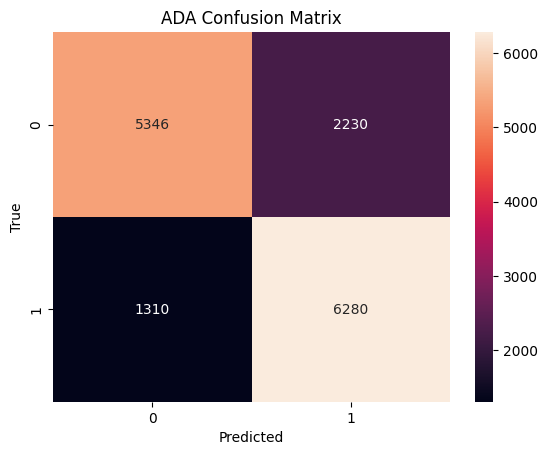

In [116]:
sns.heatmap(confusion_matrix(y_test,ada_pred),annot=True,fmt='d')
plt.title("ADA Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True');

In [117]:
print(classification_report(y_test,ada_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75      7576
         1.0       0.74      0.83      0.78      7590

    accuracy                           0.77     15166
   macro avg       0.77      0.77      0.77     15166
weighted avg       0.77      0.77      0.77     15166



In [118]:
ada_fpr,ada_tpr,ada_thresholds = roc_curve(y_test,ada_pred)
ada_auc = auc(ada_fpr,ada_tpr)

---

### 6. Voting Classifier

In a last step I try to combine several models in order to improve their Accuracy and F1-Score. Because with have a binary Classification - either successful or not successful offer - I will use a Voting Classificator.

I will combine the following models:
* SVC
* Logistic Regression
* ADA

In [119]:
# Voting Classifier
voting = VotingClassifier(estimators=[
    ('SVC', svc3),
    ('lr', model),
    ('ADA', ada)],
    voting='hard')

In [121]:
voting.fit(X_train,y_train)
voting_pred = voting.predict(X_test)
voting_f1 = f1_score(y_test, voting_pred)
voting_accuracy = accuracy_score(y_test,voting_pred)

print("Voting Model Accuracy: %.4f" % voting_accuracy)
print("Voting Model F1 Accuracy: %.4f" % voting_f1)

Voting Model Accuracy: 0.5489
Voting Model F1 Accuracy: 0.6050


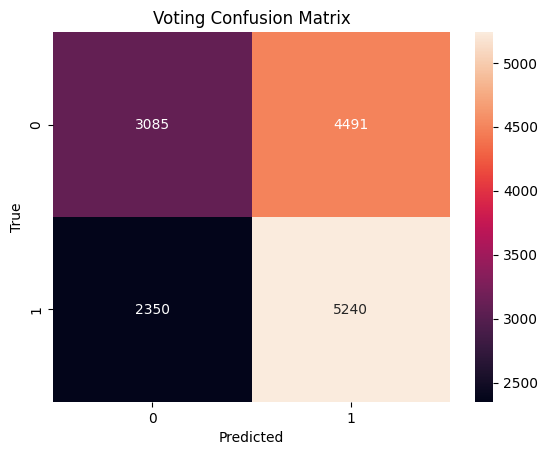

In [122]:
sns.heatmap(confusion_matrix(y_test,voting_pred),annot=True,fmt='d')
plt.title("Voting Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True');

In [123]:
voting_fpr,voting_tpr,voting_thresholds = roc_curve(y_test,voting_pred)
voting_auc = auc(voting_fpr,voting_tpr)

---

# Conclusion

---

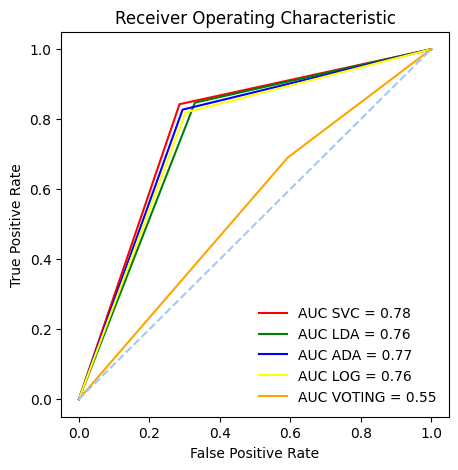

In [124]:
#Plot the auc 
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(svc_fpr,svc_tpr, color='red',label = 'AUC SVC = %0.2f' % roc_auc)
plt.plot(lda_fpr,lda_tpr,color='green',label = 'AUC LDA = %0.2f' % lda_auc)
plt.plot(ada_fpr,ada_tpr,color='blue',label='AUC ADA = %0.2f' % ada_auc)
plt.plot(log_fpr,log_tpr,color='yellow',label = 'AUC LOG = %0.2f' % log_auc)
plt.plot(voting_fpr,voting_tpr,color='orange',label='AUC VOTING = %0.2f' % voting_auc)
plt.legend(loc = 'lower right',frameon=False)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [125]:
accuracy = np.array([log_accuracy,log2_accuracy,svc_accuracy,svc2_accuracy,svc3_accuracy,lda_accuracy,ada_accuracy, voting_accuracy]).reshape(-1,1)
f1_score = np.array([log_f1_score,log2_f1,svc_f1,svc2_f1,svc3_f1_score,lda_f1,ada_f1, voting_f1]).reshape(-1,1)

metrics = pd.DataFrame(np.concatenate((accuracy,f1_score),axis=1),columns=['Accuracy','F1 Score'])

model_names = np.array(['Logistic Regresson 1','Logistic Regression 2','SVC Linear','SVC RBF 1','SVC RBF 2','LDA','ADA', 'Voting']).reshape(-1,1)

metrics = pd.concat([metrics,pd.DataFrame(model_names)],axis=1)

metrics.columns = ['Accuracy','F1 Score','Model Names']

metrics.set_index('Model Names').sort_values(by='Accuracy',ascending=False)

Accuracy  F1 Score
Model Names                              
SVC RBF 2              0.786312  0.796543
SVC RBF 1              0.778908  0.792908
ADA                    0.766583  0.780124
LDA                    0.759066  0.778760
Logistic Regresson 1   0.758627  0.773159
Logistic Regression 2  0.758627  0.773159
SVC Linear             0.736093  0.774023
Voting                 0.548925  0.605046

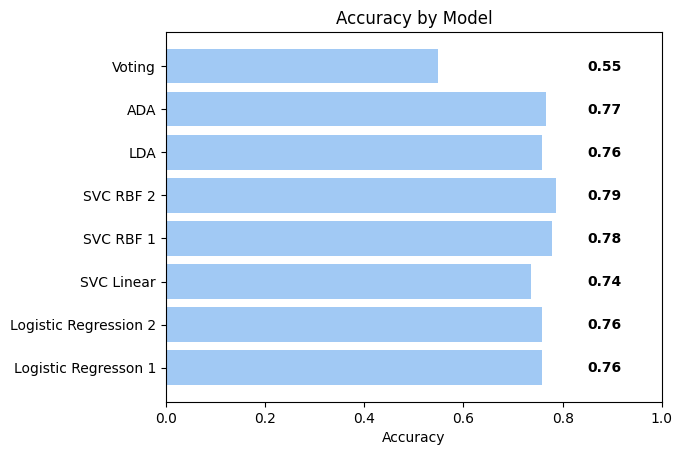

In [126]:
plt.barh(metrics['Model Names'],metrics['Accuracy']);
plt.xlabel('Accuracy')
plt.title('Accuracy by Model')
plt.xlim([0,1])


labels = ['%.2f' % x for x in metrics['Accuracy']]


for i,v in enumerate(metrics['Accuracy']):
    plt.gca().text(0.85, i - 0.1, labels[i], color='black', fontweight='bold')

As the results show the Support Vector Machine model with Radial Basic Function and the parameter C at 100 (SVC RBF 2)  delivers the best results in both Accuracy and F1-Score. With an accuracy of almost 80% the model can predict whether an offer will be successful or not. Looking at the feature effects you can see that the gender has a huge effect on the success of an offer.

Before launching an offer I would suggest using the SVC RBF2 model to calculate if an offer would be successful.
We can calculate the success rate of a campaign based on the forecasting of the model.

---

# Further Optimization

---

For further optimization of the model it would be useful to train a more diverse model. Right now it is only possible to predict, if an offer will be successful or not. It would be interestig to analyze what offer is most successful with what type of potential customer. With these information a campaign could be more personalized. Right now we could only launch a general campaign for every customer and calculate the success rate. 